In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
# from fastai.callbacks import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config

from dsin.train_utils.visibilty_utils.logger_cb_utils import setup_file_logger
from dsin.train_utils.visibilty_utils.pbar_cb_utils import (AverageMetric,
                                            ParameterMetricCallback,
                                            ProgressBarAttibuteVisualizer,
                                            ParameterRunningAverageMetricCallback,
                                            BitEntropy
                                           )
from dsin.train_utils.save_utils import FileNameGenerator

In [3]:
bpp = 0.1
H_target = 2* bpp
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

250

In [4]:
logger = setup_file_logger()

In [5]:
config.use_si_flag = SiNetChannelIn.WithSideInformation

In [6]:
baseline_autoencoder = BaseAutoEncoder()
path = "../src/dsin/data"
pct= 1 # 0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_val.txt"],pct=pct/10)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)


tfms =  get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1., max_lighting=None, max_warp=None, p_affine=0.0, p_lighting=0.0)

batchsize = 1

data = (image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 1224), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))

learn = Learner(data=data,
                     model=baseline_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(baseline_autoencoder,SiNetChannelIn.NoSideInformation,target_bit_cost = H_target),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])

In [9]:
model_fname =FileNameGenerator.create_fname(f'try2-MAE-l2reg-baseline-bpp0p{bpp*100:.0f}')
lrs = [1e-3,1e-4, 1e-5, 1e-5]
model_fname,lrs

('2020-08-27try2-MAE-l2reg-baseline-bpp0p10', [0.001, 0.0001, 1e-05, 1e-05])

In [ ]:
config.si_loss_weight_alpha = 0
learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
    
offset = 0
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0 :
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=False)])

    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.034 imp-mean-var(0.11 0.10) total loss292.3  l2reg_loss=28.5autoencoder_loss_value=21.5si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.545 imp-mean-var(0.57 0.24) total loss527.5  l2reg_loss=40.6autoencoder_loss_value=40.8si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.511 imp-mean-var(0.73 0.20) total loss491.2  l2reg_loss=43.4autoencoder_loss_value=42.1si_loss=0.0feat_loss_value=0.0
iter 1500: bpp = 0.495 imp-mean-var(0.80 0.16) total loss461.5  l2reg_loss=64.3autoencoder_loss_value=32.5si_loss=0.0feat_loss_value=0.0
iter 2000: bpp = 0.461 imp-mean-var(0.86 0.12) total loss475.2  l2reg_loss=85.8autoencoder_loss_value=48.1si_loss=0.0feat_loss_value=0.0
iter 2500: bpp = 0.473 imp-mean-var(0.83 0.14) total loss522.9  l2reg_loss=93.0autoencoder_loss_value=36.4si_loss=0.0feat_loss_value=0.0
iter 3000: bpp = 0.311 imp-mean-var(0.08 0.07) total loss365.4  l2reg_loss=153.2autoencoder_loss_value=39.6si_loss=0.0feat_loss_value=0.0
iter 3500: bpp = 0.357 imp-mean-var(0.25 0.1

In [13]:
 learn.save(f'{model_fname}-{i}')
 !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
 !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


upload: ../src/dsin/data/models/2020-08-26-16-09MAE-l2reg-baseline-0.pth to s3://dsin-us/models/2020-08-26-16-09MAE-l2reg-baseline-0.pth
upload: ./out.log to s3://dsin-us/models/2020-08-26-16-09MAE-l2reg-baseline.log


In [ ]:
learn.save(f'{model_fname}-{i}')

!aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
!aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


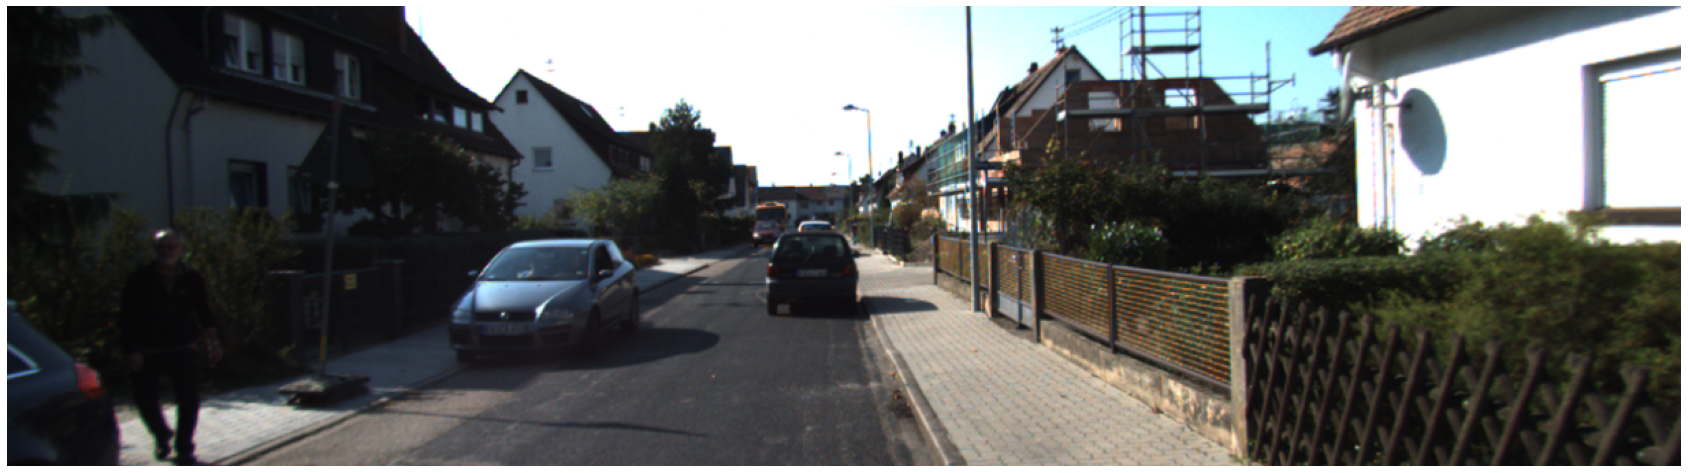

In [18]:
mt = learn.model.my_tuple[-3].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
show_image(Image(mt),figsize=(30,30))
# # print(mn)

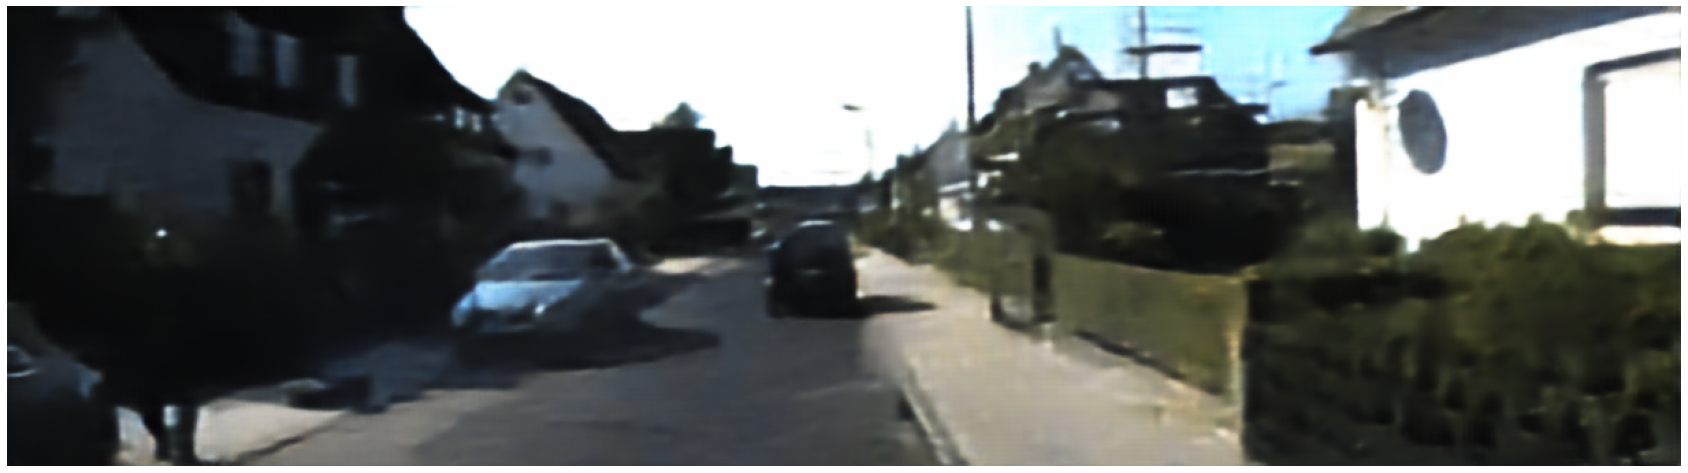

In [19]:
mt = learn.model.my_tuple[3].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
show_image(Image(mt),figsize=(30,30))